In [ ]:
# 신경망 연습
1. power temp 데이터 만들기
2. time, power로 temp 예측하는 신경망 만들어보기
3. 깊이 조절해보기


# 1. power temp 데이터 만들기

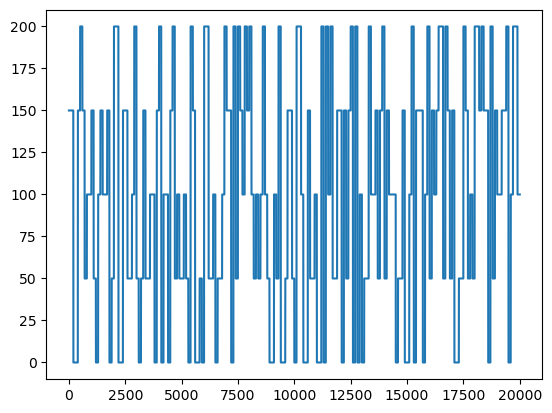

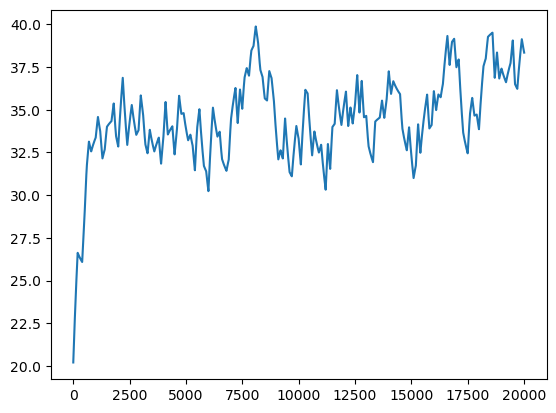

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

time = np.arange(0, 20000+5,5) # 5간격으로 0~20000까지 데이터 생성

power = np.zeros_like(time, dtype=float)
power_levels = [0, 50, 100, 150, 200] 

# 여러 power 값으로 time이랑 길이 맞춘 데이터 생성
for i in range(0, len(time), 20):
    power[i:i+20] = np.random.choice(power_levels)

# Temperature: simulate smooth response to power using exponential smoothing
temperature = np.zeros_like(time, dtype=float)
T_env = 25
T0 = 20
T = T0
alpha = 0.01
for i in range(len(time)):
    T_inf = T_env + power[i] / 10
    T = alpha * T_inf + (1 - alpha) * T
    temperature[i] = T

plt.plot(time ,power)
plt.show()
plt.plot(time ,temperature)

df = pd.DataFrame({
    "time": time,
    "power": power,
    "temp": temperature
})

# 2. time, power로 temp 예측하는 신경망 만들어보기
1. 미분 특성을 잘 연결하기 위해 중간층은 Tanh, 마지막층은 연속값으로 나오게 활성함수

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


class PINN(nn.Module):
    def __init__(self, h_init=1,  m_init=1 ):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 1)
        )
        self.h_param = nn.Parameter(torch.tensor([h_init], dtype=torch.float32))
        self.m_param = nn.Parameter(torch.tensor([m_init], dtype=torch.float32))
    

    def forward(self, t, p):
        t_norm = t / t_max
        p_norm = p / 200.0  # assuming P(t) ∈ [0, 200]
        x = torch.cat([t_norm, p_norm], dim=1)
        return self.net(x)


def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]


# initial condifion loss 추가해야 함.

def thermal_residual_loss(model, h_scale, m_scale):
    t = t_obs
    t.requires_grad_(True)
    P = P_obs
    T = model(t, P)
    dTdt = grad(T, t) / t_max
    h = model.h_param * h_scale
    m = model.m_param * m_scale
    rhs = P / (m * c) - (h * A) / (m * c) * (T - T_env)
    return torch.mean((dTdt - rhs) ** 2)




In [6]:
df.head()

,time,power,temp
0,0,150.0,20.200000
1,5,150.0,20.398000
2,10,150.0,20.594020
3,15,150.0,20.788080
4,20,150.0,20.980199


In [21]:

# Constants
h = 1
h_scale = 30
m = 1
m_scale = 450
c = 420
A = 1
T_env = 25
T0 = df['temp'].values[0]
P =df['power'].values
times = df['time'].values
t_min = times[0]
t_max = times[-1]
t_obs = torch.tensor(times, dtype=torch.float32).reshape(-1,1)
T_obs = torch.tensor(df['temp'].values, dtype=torch.float32).reshape(-1,1)
P_obs = torch.tensor(P, dtype=torch.float32).reshape(-1,1)
t_points = len(df)


In [29]:
def train_model(h_scale, m_scale, c, A):
    h_init = 1
    m_init = 1
    c = c
    A = A
    loss2_weight = 1.0
    epochs = 100
    model = PINN(h_init=h_init, m_init=m_init).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    mse = nn.MSELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        T_pred_obs= model(t_obs, P_obs)
        loss_main = mse(T_pred_obs, T_obs)
        loss_res = thermal_residual_loss(model, h_scale, m_scale)
        loss = loss_main + loss_res
        loss.backward()
        optimizer.step()
        
        # if epoch % 500 == 0:
        #     print(f"Epoch {epoch} | Loss: {loss.item():.5f} | h: {model.h_param.item():.4f} | m: {model.m_param.item():.2f}")

    return (model, loss)




import numpy as np 
best_loss = float('inf')
best_model = None
best_params = None
for trial in range(10):
    h_scale = np.random.randint(20, 80)
    m_scale = (np.random.randint(1,100))/100000
    model, loss = train_model(h_scale, m_scale, c, A)
    validation_loss = loss
    if validation_loss < best_loss:
        best_loss = validation_loss
        best_model = model
        best_params = {
            'h_scale':h_scale,
            'm_scale':m_scale}
        print(f" Loss: {loss.item():.5f} | h: {model.h_param.item():.4f} | m: {model.m_param.item():.2f}")


 Loss: 2384401.50000 | h: 0.9597 | m: 1.04
 Loss: 2117587.50000 | h: 0.9606 | m: 1.04


In [28]:
model

10336282.0